In [1]:
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.preprocessing import StandardScaler
from xgboost import plot_importance
import matplotlib.pyplot as plt
import xgboost as xgb
import pandas as pd
import numpy as np

pd.set_option("display.max_columns", None)

In [2]:
identifier_name = 'flight_id'

most_important_features_names = [
     'wtc',
     'flown_distance',
     'aircraft_type',
     'longitude_max',
     'altitude_median',
     'groundspeed_max',
     'airline',
     'groundspeed_75percentile',
     'altitude_25percentile',
     'flight_duration',
     'latitude_min',
     'vertical_rate_std',
     'altitude_75percentile',
     'longitude_median',
     'longitude_std',
     'vertical_rate_25percentile',
     'longitude_min',
     'longitude_mean',
     'adep',
     'vertical_rate_max',
     'ades',
     'latitude_std',
     'latitude_max',
     'longitude_25percentile',
     'altitude_mean',
     'latitude_mean',
     'vertical_rate_75percentile',
     'latitude_median',
     'groundspeed_min',
     'country_code_adep',
     'country_code_ades',
     'latitude_25percentile',
     'longitude_count',
     'groundspeed_25percentile',
     'vertical_rate_min',
     'longitude_75percentile',
     'track_75percentile',
     'taxiout_time',
     'track_median',
     'vertical_rate_median',
     'latitude_75percentile',
     'track_25percentile',
     'month_day',
     'latitude_count',
     'altitude_std',
     'arrival_time_hour',
     'track_mean',
     'arrival_time_hour_minute',
     'vertical_rate_mean'
]

target_name = 'tow'

global_random_state = 123

In [3]:
encoded_challenge_set = pd.read_csv('data/encoded_challenge_set.csv')

features = encoded_challenge_set[most_important_features_names].copy()
display(features)

target = encoded_challenge_set[[target_name]].copy()
display(target)

,wtc,flown_distance,aircraft_type,longitude_max,altitude_median,groundspeed_max,airline,groundspeed_75percentile,altitude_25percentile,flight_duration,latitude_min,vertical_rate_std,altitude_75percentile,longitude_median,longitude_std,vertical_rate_25percentile,longitude_min,longitude_mean,adep,vertical_rate_max,ades,latitude_std,latitude_max,longitude_25percentile,altitude_mean,latitude_mean,vertical_rate_75percentile,latitude_median,groundspeed_min,country_code_adep,country_code_ades,latitude_25percentile,longitude_count,groundspeed_25percentile,vertical_rate_min,longitude_75percentile,track_75percentile,taxiout_time,track_median,vertical_rate_median,latitude_75percentile,track_25percentile,month_day,latitude_count,altitude_std,arrival_time_hour,track_mean,arrival_time_hour_minute,vertical_rate_mean
0,1,321,4,-0.443802,26175.0,390.0,20,368.0,9550.00,61,51.453232,1609.709745,32000.0,-4.895513,2.655620,-704.0,-8.574295,-4.817843,70,5568.0,82,0.161396,52.028643,-7.346304,20991.546763,51.837035,368.0,51.892997,102.0,37,36,51.774945,3614,260.25,-5696.0,-2.418875,275.911467,18,274.162435,0.0,51.942919,270.944437,0,3614,11779.780447,15,266.916090,904,9.470294
1,0,4193,18,2.097078,33000.0,495.0,10,484.0,33000.00,570,25.803905,691.174222,38000.0,-60.346413,32.832625,0.0,-80.492389,-37.864321,220,3328.0,168,6.193836,43.390968,-66.559062,29599.616239,36.416839,0.0,35.748230,109.0,33,80,31.443732,10358,431.00,-1984.0,-4.094342,283.594836,13,238.620818,0.0,42.505463,230.543696,0,10358,11763.166165,19,249.189327,1177,80.330693
2,0,3770,7,17.939514,36000.0,470.0,18,406.0,24275.00,554,41.965164,687.891983,36000.0,-22.770120,43.183849,0.0,-88.239066,-33.600731,139,3072.0,171,8.598085,63.104782,-85.001760,29266.370244,54.653675,0.0,60.114143,89.0,88,80,44.087809,12932,334.00,-1728.0,7.996781,278.778859,15,269.252706,0.0,61.133171,227.842138,0,12932,12070.365491,19,245.620910,1148,-38.192179
3,0,3607,21,8.637296,38000.0,478.0,10,460.0,30000.00,497,39.524386,670.081295,39975.0,-59.086533,33.535859,-64.0,-75.200562,-36.308858,343,4224.0,172,4.887211,54.923820,-69.237322,32681.139500,47.313159,0.0,47.763176,104.0,19,80,42.496536,17534,404.00,-2112.0,-2.139416,294.800965,11,271.127724,-64.0,51.502545,228.858036,0,17534,11549.367080,19,259.543237,1172,-47.593019
4,1,305,1,0.029984,16850.0,498.0,20,430.0,7025.00,55,51.464942,1609.815425,31000.0,-1.853394,2.100484,-896.0,-6.399455,-2.412936,93,4224.0,60,0.731746,53.426793,-4.134391,17836.102603,52.449270,768.0,52.485926,123.0,44,27,51.682892,3265,260.00,-3072.0,-0.433886,139.555775,14,137.428049,-256.0,53.206329,99.056120,0,3265,11661.560716,13,145.083718,824,-14.074119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369008,0,4046,21,2.558947,34000.0,521.0,10,477.0,28768.75,545,25.811234,870.857796,36975.0,-62.147083,34.354707,-64.0,-80.441687,-40.831541,257,4160.0,168,9.563126,49.090393,-69.023288,29688.784438,38.877157,0.0,34.402197,137.0,36,80,32.045397,10744,380.00,-2688.0,-4.419947,270.751870,21,251.458355,-64.0,49.029201,245.099119,364,10744,10902.804318,19,246.708174,1143,-65.664288
369009,1,946,1,28.944917,34000.0,426.0,14,395.0,30787.50,158,41.182114,856.019220,34025.0,21.143944,4.738333,-64.0,13.501244,21.168711,391,3584.0,15,3.546660,52.425594,17.159999,29129.706377,47.262027,0.0,47.335968,101.0,96,19,44.200717,9519,372.00,-2240.0,25.316283,319.431039,25,315.432413,0.0,50.561453,313.032203,364,9519,9628.394713,12,309.516435,749,-10.504150
369010,1,522,4,6.777954,35975.0,381.0,20,336.0,20368.75,99,51.266816,1231.417354,36000.0,0.316788,4.047513,-64.0,-6.267151,0.286890,30,3840.0,83,0.735722,53.728592,-3.278382,27860.307460,52.913110,64.0,53.203024,93.0,26,36,52.352230,5952,314.00,-4032.0,3.818993,293.930164,11,281.587728,0.0,53.526403,278.953705,364,5952,11773.056560,11,281.881408,701,3.408602
369011,1,466,1,2.556927,35375.0,473.0,20,365.0,1

,tow
0,54748.000000
1,185441.000000
2,230396.000000
3,157615.000000
4,70318.447226
...,...
369008,163438.000000
369009,78707.000000
369010,62942.750000
369011,72611.161024


In [4]:
# Function to score model using Root Mean Square Error
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
    
# Create a scorer
rmse_scorer = make_scorer(rmse, greater_is_better=False)

# Make cross validation strategy
cv_strategy = KFold(n_splits=3, shuffle=True, random_state=global_random_state)

In [5]:
param_grid = {
    'max_depth': np.arange(1, 17, 1),
}

model = xgb.XGBRegressor(
    objective='reg:squarederror', 
    eval_metric='rmse',
    random_state=global_random_state,
    n_estimators=850,
    learning_rate=0.2,
    subsample=1.0,
    colsample_bytree=0.9,
    min_child_weight=10, 
)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error', # Use RMSE (negative because scikit-learn maximizes scores)
    cv=cv_strategy,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(features, target)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


GridSearchCV(cv=KFold(n_splits=3, random_state=123, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.9,
                                    device=None, early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric='rmse', feature_types=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    in...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=10, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=850,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=123, ...),
             n_jobs=-1,
             param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])},
             scoring='neg_root_mean_squared_error', verbose=2)

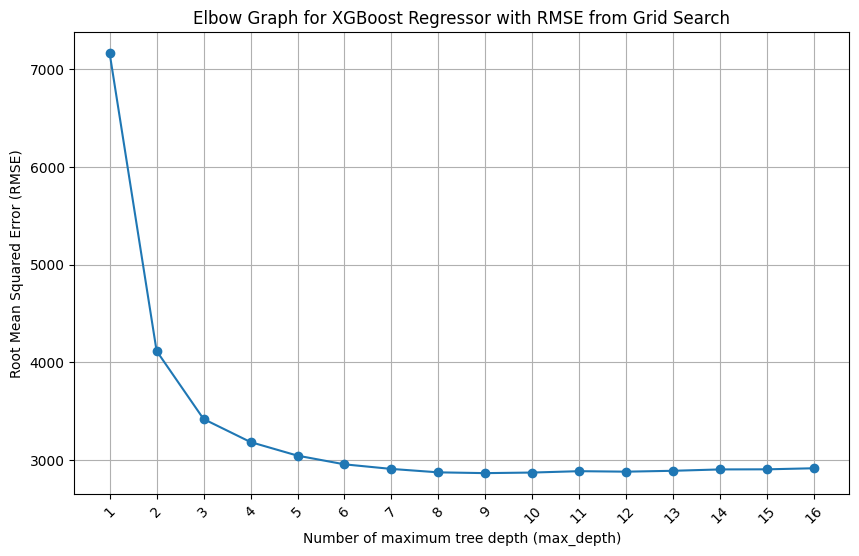

Best Parameters: {'max_depth': 9}
Best RMSE: 2865.7584590024703


In [6]:
results = grid_search.cv_results_

rmse_values = np.round(-results['mean_test_score'])

plt.figure(figsize=(10, 6))
plt.plot(results['param_max_depth'], rmse_values, marker='o')
plt.title('Elbow Graph for XGBoost Regressor with RMSE from Grid Search')
plt.xlabel('Number of maximum tree depth (max_depth)')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.xticks(results['param_max_depth'], rotation=45)
plt.grid()
plt.show()

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best RMSE:", -grid_search.best_score_)

In [7]:
print(results['param_max_depth'])

[1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16]


In [8]:
print(rmse_values)

[7166. 4117. 3420. 3184. 3045. 2956. 2909. 2874. 2866. 2872. 2886. 2881.
 2890. 2904. 2905. 2916.]
